In [1]:
%matplotlib inline
%load_ext rpy2.ipython

In [2]:
from __future__ import division, unicode_literals, print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.formula.api as smf

## 1. 前処理 (続き)

In [3]:
df = pd.read_csv('result_congruency.csv')
df.head()

,subj,congruency,RT
0,1,congruent,375.800000
1,1,incongruent,479.125000
2,2,congruent,380.000000
3,2,incongruent,492.852941
4,3,congruent,387.875000


In [4]:
# 被験者条件を潰して，もう一度集計
df_groupby = df.groupby(by=['congruency'])
df_mean = df_groupby['RT'].mean()
df_sem = df_groupby['RT'].sem()

In [5]:
# 独自の関数を適用 (apply) することもできる
def cilen(arr, alpha=0.95):  # 両側95%信頼区間
    m, e, df = np.mean(arr), stats.sem(arr), len(arr) - 1
    interval = stats.t.interval(alpha, df, loc=m, scale=e)
    cilen = np.max(interval) - np.mean(interval)
    return cilen

df_ci = df_groupby['RT'].apply(cilen)

## 2. 可視化
作図方法については[公式のギャラリー](http://matplotlib.org/gallery.html)を参照すると良い．

### 2.1. ざっくりプロット

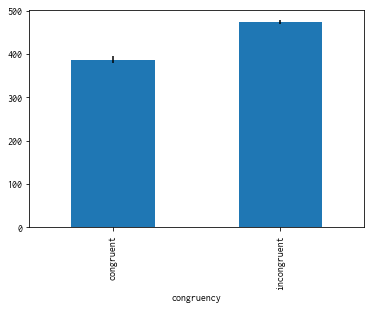

In [6]:
df_mean.plot(kind='bar', yerr=df_sem)

### 2.2. しっかりプロット

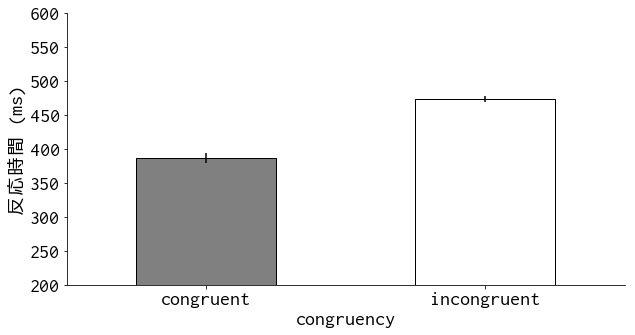

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))
df_mean.plot(
    kind='bar',
    rot=0,  # ラベルの回転を0度に設定
    yerr=df_sem,
    color=('gray', 'white'),
    edgecolor='black',
    fontsize=20,
    ax=ax
)

ax.set_xlabel('congruency', fontsize=20)
ax.set_ylabel('反応時間 (ms)', fontsize=20)
ax.set_ylim(200, 600)
ax.spines['right'].set_visible(False)  # 右側の枠を消す
ax.spines['top'].set_visible(False)  # 上側の枠を消す

## 3. 分析
### 3.1. t検定

In [8]:
table = df.set_index(['subj', 'congruency'])['RT'].unstack()
table.head()

congruency,congruent,incongruent
subj,,
1,375.800000,479.125000
2,380.000000,492.852941
3,387.875000,471.363636
4,353.647059,471.583333
5,383.333333,494.500000


#### 対応あり

In [9]:
t, p = stats.ttest_rel(table['congruent'], table['incongruent'])
print(t, p)

-9.41180511456 1.38465046153e-08


In [10]:
%%R
dat <- read.csv('result_congruency.csv')
dat.c <- dat[dat$congruency == 'congruent', 'RT']
dat.i <- dat[dat$congruency == 'incongruent', 'RT']
t.test(dat.c, dat.i, paired = T)  # もちろん，Rの場合と一致する


	Paired t-test

data:  dat.c and dat.i
t = -9.4118, df = 19, p-value = 1.385e-08
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -105.58562  -67.16815
sample estimates:
mean of the differences 
              -86.37689 



#### 対応なし

In [11]:
t, p = stats.ttest_ind(table['congruent'], table['incongruent'])
print(t, p)

-9.91026349597 4.38352228745e-12


In [12]:
%%R
t.test(dat.c, dat.i, paired = F)


	Welch Two Sample t-test

data:  dat.c and dat.i
t = -9.9103, df = 31.938, p-value = 2.885e-11
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -104.13195  -68.62182
sample estimates:
mean of x mean of y 
 386.9838  473.3607 



### 3.2. 分散分析
Pythonのstatsmodelsでは反復測定ANOVAの分析ができません．分散分析だけはRを呼んだほうが楽です (ほかにPythonでできないこととして，一般化線形混合モデルが挙げられます)．

Rで分散分析するならaov…に見せかけて，楽したいという人はanova君を使うのが最も良いです．

In [13]:
%%R
source('anovakun_462.txt')
anovakun(dat, 'sA', long=T, peta=T, holm=T)  # anova君にお任せするなら


[ sA-Type Design ] 
 
This output was generated by anovakun 4.6.2 under R version 3.3.2. 
It was executed on Sun Feb 26 17:54:05 2017. 
 
 
<< DESCRIPTIVE STATISTICS >>

--------------------------------------
  congruency   n      Mean     S.D. 
--------------------------------------
   congruent  20  386.9838  33.0247 
 incongruent  20  473.3607  20.7053 
--------------------------------------


<< SPHERICITY INDICES >>

== Mendoza's Multisample Sphericity Test and Epsilons == 
 
---------------------------------------------------------------------------
     Effect  Lambda  approx.Chi df       p         LB     GG     HF     CM 
---------------------------------------------------------------------------
 congruency  1.0000     -0.0000  0             1.0000 1.0000 1.0000 1.0000 
---------------------------------------------------------------------------
                                 LB = lower.bound, GG = Greenhouse-Geisser 
                                 HF = Huynh-Feldt-Lecoutr

### 3.3. 線形混合モデル (LME)
Pythonでは一般化線形混合モデル (GLMM) を使うライブラリは存在しません．しかし線形混合モデルならなら利用可能です．

分散分析なんて古臭い！これからは混合モデルの時代だ！という人ならPythonでもやれます．

次のブロックに示したコードは，以下のコードのようにRのlme4を用いた場合と同じ結果を示します．

```
library(lme4)
d <- read.csv('result_congruency.csv')
fit <- lmer(RT ~ congruency + (1 | subj), data = d)
summary(fit)
```

In [14]:
model = smf.mixedlm('RT ~ congruency', data=df, groups=df['subj']).fit()
model.summary()

/Users/masataka/anaconda/lib/python3.5/site-packages/statsmodels/regression/mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
=======================================================================
Model:                  MixedLM      Dependent Variable:      RT       
No. Observations:       40           Method:                  REML     
No. Groups:             20           Scale:                   759.6695 
Min. group size:        2            Likelihood:              -182.9402
Max. group size:        2            Converged:               Yes      
Mean group size:        2.0                                            
-----------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------------------
Intercept                 386.984    6.163 62.791 0.000 374.904 399.063
congruency[T.incongruent]  86.377    8.716  9.910 0.000  69.294 103.460
groups RE                   0.000    7.203                             
=======================================================================

"""